In [1]:
import numpy as np
from numba import jit
import sys
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, fsolve
import networkx as nx
import graph_ensembles.methods as ge
import graph_ensembles.iterative_models as gei
import time

%matplotlib inline

# Auxiliary Functions

In [2]:
def density_solver(p_fun, L, z0):
    return least_squares(lambda x: p_fun(x) - L, z0, bounds = (0,np.inf))

In [3]:
@jit(nopython=True)
def nonzero_strengths(strenghts):
    ind1,ind2 = strenghts.nonzero()
    aux_strengths = []
    for ii,jj in zip(ind1,ind2):
        aux_strengths.append(strenghts[ii,jj])
    return np.dstack((ind1,ind2,np.array(aux_strengths)))[0]

In [4]:
@jit(nopython=True)
def nonzero_strengths_block(strenghts, group_array):
    ind1,ind2 = strenghts.nonzero()
    aux_strengths = []
    aux_sect = []
    for ii,jj in zip(ind1,ind2):
        aux_sect.append(group_array[ii])
        aux_strengths.append(strenghts[ii,jj])
    return np.dstack((ind1, np.array(aux_sect), ind2, np.array(aux_strengths)))[0]

In [5]:
@jit(forceobj=True)
def dict_sect_to_array(dict_sect):
    """
    Function converting the dictionary mapping each node
    to the corresponding sector into a numpy array where 
    the node label correspond to the array index.

    Parameters
    ----------
    p: dict
        a dictionary that given the index of a node returns its group
    Returns
    -------
    np.ndarray
        an array mapping each node to its group
    """
    tmp_arr_sec = np.zeros(len(dict_sect.keys()),dtype=int)
    for key in dict_sect.keys():
        tmp_arr_sec[key] = dict_sect[key]
    return tmp_arr_sec

In [6]:
@jit(nopython=True)
def weights_for_stripe(out_strength, group_array):
    """
    Function computing the number of links going out
    from each sector.
    
    Parameters
    ----------
    out_strength: np.ndarray
        nonzero out strengths
    group_dict: dict
        a dictionary that given the index of a node returns its group
    weighted: bool
    Returns
    -------
    np.ndarray
        an array where each entry i is the number of going out links 
        from sector i.
    """

    sect = np.unique(group_array)
    n_sect = sect.shape[0]
    links_for_sect = np.zeros(n_sect)
    for i in np.arange(out_strength.shape[0]):
        sect_out = int(out_strength[i,1])
        s_out = out_strength[i,2]
        links_for_sect[sect_out] += s_out
    return(links_for_sect)


@jit(nopython=True)
def weights_for_block(out_strength,group_array):
    """
    Function computing the number of links going from
    one sector i to sector j for every possible couple i-j.

    Parameters
    ----------
    adj: np.ndarray
        the binary adjacency matrix
    group_dict: dict
        a dictionary that given the index of a node returns its group
    Returns
    -------
    np.ndarray
        an array where each entry i,j is the number of links going
        from sector i to sector j.
    """

    sect = np.unique(group_array)
    n_sect = sect.shape[0]
    links_for_sect = np.zeros(shape=(n_sect,n_sect))
    for i in np.arange(out_strength.shape[0]):
        ind_out = int(out_strength[i,0])
        sect_ind_out = int(out_strength[i,1])
        sect_out = int(out_strength[i,2])
        s_out = out_strength[i,3]
        links_for_sect[sect_ind_out,sect_out] += s_out
    return(links_for_sect)

In [7]:
@jit(nopython=True)
def links_for_stripe(adjacency, group_array):
    """
    Function computing the number of links for stripe.
    """
    sect = np.unique(group_array)
    n_sect = sect.shape[0]
    links_for_sect = np.zeros(n_sect)
    ind1,ind2 = adjacency.nonzero()
    for i, j in zip(ind1, ind2):
        sect_i = int(group_array[i])
        links_for_sect[sect_i] += 1
    return links_for_sect
    
    
@jit(nopython=True)
def links_for_block(adjacency,group_array):
    """
    Function computing the number of links for block.
    """
    sect = np.unique(group_array)
    n_sect = sect.shape[0]
    links_for_sect = np.zeros(shape=(n_sect,n_sect))
    ind1,ind2 = adjacency.nonzero()
    for i, j in zip(ind1, ind2):
        sect_i = int(group_array[i])
        sect_j = int(group_array[j])
        links_for_sect[sect_i,sect_j] += 1
    return links_for_sect

In [8]:
@jit(nopython=True)
def strengths_stripe_organised(adj_weighted, array_sectors):
    n_sectors = np.unique(array_sectors).shape[0]
    n_nodes = adj_weighted.shape[0]
    out_strengths = np.zeros(shape=(n_nodes,
                                    n_sectors))
    in_strengths = np.zeros(shape=(n_nodes,
                                   n_sectors))
    
    for i in np.arange(n_nodes):
        out_strengths[i,array_sectors[i]] += adj_weighted[i,:].sum()
        for j in np.arange(n_nodes):
            if adj_weighted[i,j]:
                in_strengths[j,array_sectors[i]] += adj_weighted[i,j]
    return out_strengths, in_strengths

In [9]:
@jit(nopython=True)
def strengths_block_organised(adj_weighted, array_sectors):
    n_sectors = np.unique(array_sectors).shape[0]
    n_nodes = adj_weighted.shape[0]
    out_strengths = np.zeros(shape=(n_nodes,
                                    n_sectors))
    in_strengths = np.zeros(shape=(n_nodes,
                                   n_sectors))
    
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if adj_weighted[i,j]:
                out_strengths[i, array_sectors[j]] += adj_weighted[i, j]
                in_strengths[j, array_sectors[i]] += adj_weighted[i, j]
    return out_strengths, in_strengths

# Creating the Network

In [10]:
# Generate toplogy
hyp_dim = np.array([50,30,40,20,70])
n_of_sector = len(hyp_dim)
seed = 20
p=0.3

real_dim = []
adj_sectors = []
dim_list = [0]
avg_out_degree_random = []

for ii in range(n_of_sector):
    G = nx.fast_gnp_random_graph(hyp_dim[ii],p=p,directed=True)
    tmp_adj = nx.to_numpy_array(G)
    avg_out_degree_random.append(np.mean(G.out_degree))
    real_dim.append(tmp_adj.shape[0])
    dim_list.append(dim_list[ii]+real_dim[ii])
    adj_sectors.append(tmp_adj)
    
G = nx.fast_gnp_random_graph(n = np.sum(real_dim), p = 0.08, directed = True)
adj_aux_random = nx.to_numpy_array(G)


for ii in range(n_of_sector):
    
    adj_aux_random[dim_list[ii]:dim_list[ii+1]][:,dim_list[ii]:dim_list[ii+1]] = adj_sectors[ii]

tmp_ind = np.where((np.sum(adj_aux_random,axis=1) + np.sum(adj_aux_random,axis=0))>0)[0]
adj_aux_random = adj_aux_random[tmp_ind][:,tmp_ind]


# Mapping nodes to sector
dict_sectors = {}
for ii in range(n_of_sector):
    tmp = []
    for jj in range(dim_list[ii],dim_list[ii+1]):
        dict_sectors[jj] = ii

# Converting the dictionary to array
array_sectors = dict_sect_to_array(dict_sectors)
        
# Assigning Weights

adj = adj_aux_random
avg_degree = avg_out_degree_random

k_out = adj.sum(axis=1)
k_in = adj.sum(axis=0)
adj_weight = np.zeros_like(adj)


for ii in np.arange(adj.shape[0]):
    for jj in np.arange(adj.shape[0]):
        if ii!=jj:
            if adj[ii,jj]!=0:
                #adj_weight[ii,jj] = k_out[ii]*k_in[jj]
                tmp = int(k_out[ii]*k_in[jj]/(avg_degree[dict_sectors[ii]]))
                adj_weight[ii,jj] = np.random.uniform(low=np.min([5,tmp]),high=np.max([6,tmp]),size=1)

# Preparing the input data

### Strengths block

In [11]:
strengths_out_block, strengths_in_block = strengths_block_organised(adj_weighted=adj_weight, array_sectors=array_sectors)
strengths_out_stripe, strengths_in_stripe = strengths_stripe_organised(adj_weighted=adj_weight, array_sectors=array_sectors)

### Number of edges

In [12]:
L_tot = adj.sum()

### Nonzero Strengths

In [13]:
nz_out_strenght_block = nonzero_strengths_block(strengths_out_block, array_sectors)
nz_in_strenght_block = nonzero_strengths_block(strengths_in_block, array_sectors)

### Strengths for block

In [14]:
strengths_for_block = weights_for_block(nz_out_strenght_block, array_sectors)
strengths_for_stripe = weights_for_stripe(nonzero_strengths(strengths_out_stripe), array_sectors)

# Applying Methods

## Stripe Model one z

In [43]:
time_1 = time.time()
solution = density_solver(lambda x: ge.expected_links_block_one_z(
                                    nz_out_strenght_block,
                                    nz_in_strenght_block,
                                    x),
                                    L_tot,
                                    0.000003)
z_block_one = solution.x[0]
time_2 = time.time()
time_old = time_2 - time_1
P_matrix_block_one = ge.vector_fitness_prob_array_block_one_z(
                                    nz_out_strenght_block,
                                    nz_in_strenght_block,
                                    z_block_one,
                                    adj.shape[0])
print((adj>0).sum(),P_matrix_block_one.sum())

5731 5731.000000000562


## Assigning Weights

In [16]:
W_exp = ge.assign_weights_cimi_block_one_z(
                                        P_matrix_block_one,
                                        nz_out_strenght_block,
                                        nz_in_strenght_block,
                                        adj.shape[0],
                                        strengths_for_block
                                            )
print(adj_weight.sum(), W_exp.sum())

140367.98273661511 138937.3957962208


# Expected and observed Quantities 

In [17]:
exp_s_out = W_exp.sum(axis = 1)
exp_s_in = W_exp.sum(axis = 0)

s_out = adj_weight.sum(axis = 1)
s_in = adj_weight.sum(axis = 0)

In [18]:
exp_strengths_out_block, exp_strengths_in_block = strengths_block_organised(adj_weighted = W_exp,
                                                                               array_sectors = array_sectors)

In [19]:
exp_strengths_for_block = weights_for_block(nonzero_strengths_block(exp_strengths_out_block, array_sectors), array_sectors)

In [20]:
exp_strengths_out_stripe, exp_strengths_in_stripe = strengths_stripe_organised(adj_weighted = W_exp,
                                                                               array_sectors = array_sectors)
exp_strengths_for_stripe = weights_for_stripe(nonzero_strengths(exp_strengths_out_stripe), array_sectors)

## Plots

### $s_{out}$ vs $\langle s_{out} \rangle$

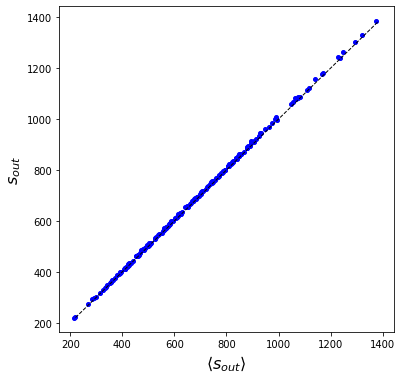

In [21]:
plt.figure(figsize=(6,6))
xy_1 = (np.min(s_out), np.max(s_out))
plt.plot(exp_s_out, s_out, marker = 'o', markersize=4, color='blue', ls='None' )
plt.plot(xy_1, xy_1, ls='--', color='black', lw=1)
plt.xlabel(r'$\langle s_{out} \rangle$', fontsize=16)
plt.ylabel(r'$s_{out}$', fontsize=16)
plt.show()

### $s_{in}$ vs $\langle s_{in} \rangle$

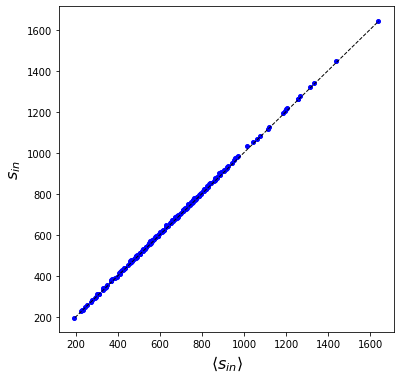

In [22]:
plt.figure(figsize=(6,6))
xy_1 = (np.min(s_in), np.max(s_in))
plt.plot(exp_s_in, s_in, marker = 'o', markersize=4, color='blue', ls='None' )
plt.plot(xy_1, xy_1, ls='--', color='black', lw=1)
plt.xlabel(r'$\langle s_{in} \rangle$', fontsize=16)
plt.ylabel(r'$s_{in}$', fontsize=16)
plt.show()

### $s_{i \rightarrow g_j}$ vs $\langle s_{i \rightarrow g_j} \rangle$

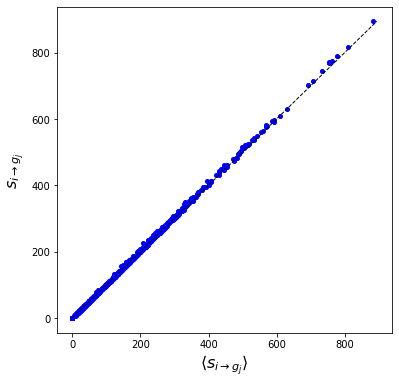

In [23]:
plt.figure(figsize=(6,6))
xy_1 = (np.min(np.reshape(strengths_out_block, -1)),
        np.max(np.reshape(strengths_out_block, -1)))
xy_2 = (np.min(np.reshape(strengths_out_block, -1)),
        np.max(np.reshape(strengths_out_block, -1)))
plt.plot(np.reshape(exp_strengths_out_block, -1), np.reshape(strengths_out_block, -1),
         marker = 'o', markersize=4, color='blue', ls='None' )
plt.plot(xy_1, xy_2, ls='--', color='black', lw=1)
plt.xlabel(r'$\langle s_{i \rightarrow g_j} \rangle$', fontsize=16)
plt.ylabel(r'$s_{i \rightarrow g_j}$', fontsize=16)
plt.show()

### $s_{g_i \rightarrow j}$ vs $\langle s_{g_i \rightarrow j} \rangle$

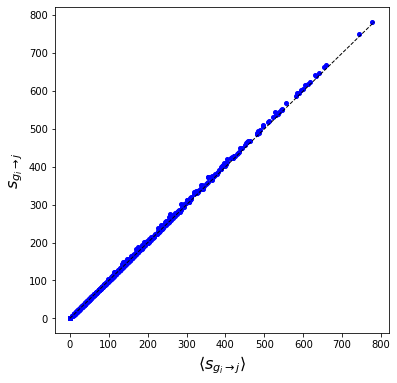

In [24]:
plt.figure(figsize=(6,6))
xy_1 = (np.min(np.reshape(strengths_in_block, -1)),
        np.max(np.reshape(strengths_in_block, -1)))
xy_2 = (np.min(np.reshape(strengths_in_block, -1)),
        np.max(np.reshape(strengths_in_block, -1)))
plt.plot(np.reshape(exp_strengths_in_block, -1), np.reshape(strengths_in_block, -1),
         marker = 'o', markersize=4, color='blue', ls='None' )
plt.plot(xy_1, xy_2, ls='--', color='black', lw=1)
plt.xlabel(r'$\langle s_{g_i \rightarrow j} \rangle$', fontsize=16)
plt.ylabel(r'$s_{g_i \rightarrow j}$', fontsize=16)
plt.show()

### $W_{g_i \rightarrow g_j}$ vs $ \langle W_{g_i \rightarrow g_j} \rangle $

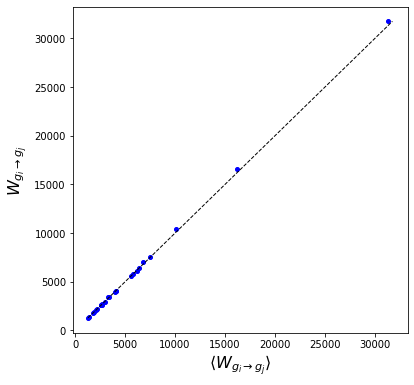

In [25]:
plt.figure(figsize=(6,6))
xy_1 = (np.min(strengths_for_block), np.max(strengths_for_block))
plt.plot(exp_strengths_for_block, strengths_for_block, marker = 'o', markersize=4, color='blue', ls='None' )
plt.plot(xy_1, xy_1, ls='--', color='black', lw=1)
plt.xlabel(r'$\langle W_{g_i \rightarrow g_j} \rangle$', fontsize=16)
plt.ylabel(r'$W_{g_i \rightarrow g_j}$', fontsize=16)
plt.show()

### Stripe Quantities

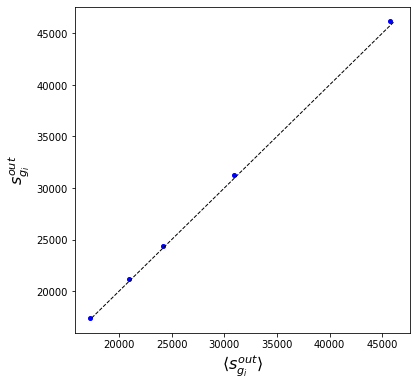

In [26]:
plt.figure(figsize=(6,6))
xy_1 = (np.min(strengths_for_stripe), np.max(strengths_for_stripe))
xy_2 = (np.min(strengths_for_stripe), np.max(strengths_for_stripe))
plt.plot(exp_strengths_for_stripe, strengths_for_stripe, marker = 'o', markersize=4, color='blue', ls='None' )
plt.plot(xy_1, xy_2, ls='--', color='black', lw=1)
plt.xlabel(r'$\langle s_{g_{i}}^{out} \rangle$', fontsize=16)
plt.ylabel(r'$ s_{g_{i}}^{out} $', fontsize=16)
plt.show()

# Iterative Methods

In [40]:
time_3 = time.time()
sol = gei.iterative_fit(z0=0.1, model='CBM-I', method='fixed-point',
                        nz_out_str = nz_out_strenght_block,
                        nz_in_str = nz_in_strenght_block,
                        L = L_tot, tol = 10e-10,
                        eps = 10e-14, max_steps=100
                        )
z_block_iter = sol[0]
steps = sol[1]
time_4 = time.time()
time_iter = time_4 - time_3

In [41]:
time_5 = time.time()
sol = gei.iterative_fit(z0=0.1, model='CBM-I', method='newton',
                        nz_out_str = nz_out_strenght_block,
                        nz_in_str = nz_in_strenght_block,
                        L = L_tot, tol = 10e-10,
                        eps = 10e-14, max_steps=100
                        )
z_block_iter = sol[0]
steps_newton = sol[1]
time_6 = time.time()
time_newton = time_6 - time_5

In [44]:
print(time_old, time_iter, time_newton, steps, steps_newton)

19.061269998550415 0.05207109451293945 0.027264118194580078 25 7


In [30]:
P_matrix_stripe_one_iter = ge.vector_fitness_prob_array_block_one_z(
                                    nz_out_strenght_block,
                                    nz_in_strenght_block,
                                    z_block_iter,
                                    adj.shape[0])
print((adj>0).sum(),P_matrix_stripe_one_iter.sum())

5731 5730.9999999999945
